### Importando os Pacotes Utilitários

In [1]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from sklearn.model_selection import train_test_split
from distutils.dir_util import copy_tree
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import tarfile, os
import numpy as np
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Baixando os Conjuntos de Dados

In [3]:
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/CheXpert-v1.0-small.zip', 
                      extract_dir = '/content/CheXpert-v1.0-small', format = 'zip')

In [4]:
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/vinbigdata.zip', 
                      extract_dir = '/content/vinbigdata/', format = 'zip')

In [5]:
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/images.zip', 
                      extract_dir = '/content/images/', format = 'zip')

### Organizando e Analisando os Dados

In [6]:
dataset = pd.read_csv('/content/all_datasets.csv', index_col = 0)
dataset = dataset[((dataset['Opacity'] == 1.0) | 
                   (dataset['Atelectasis'] == 1.0) | 
                   (dataset['Pneumothorax'] == 1.0) | 
                   (dataset['Effusion'] == 1.0)) & 
                   (dataset['Nodule/Mass'] == 0.0) &
                   (dataset['No Finding'] == 0.0)].copy()

dataset.drop(labels = 'Nodule/Mass', axis = 1, inplace = True)
dataset.drop(labels = 'No Finding', axis = 1, inplace = True)
labels = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion']
labels_portugues = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão']

Text(0, 0.5, 'Imagens')

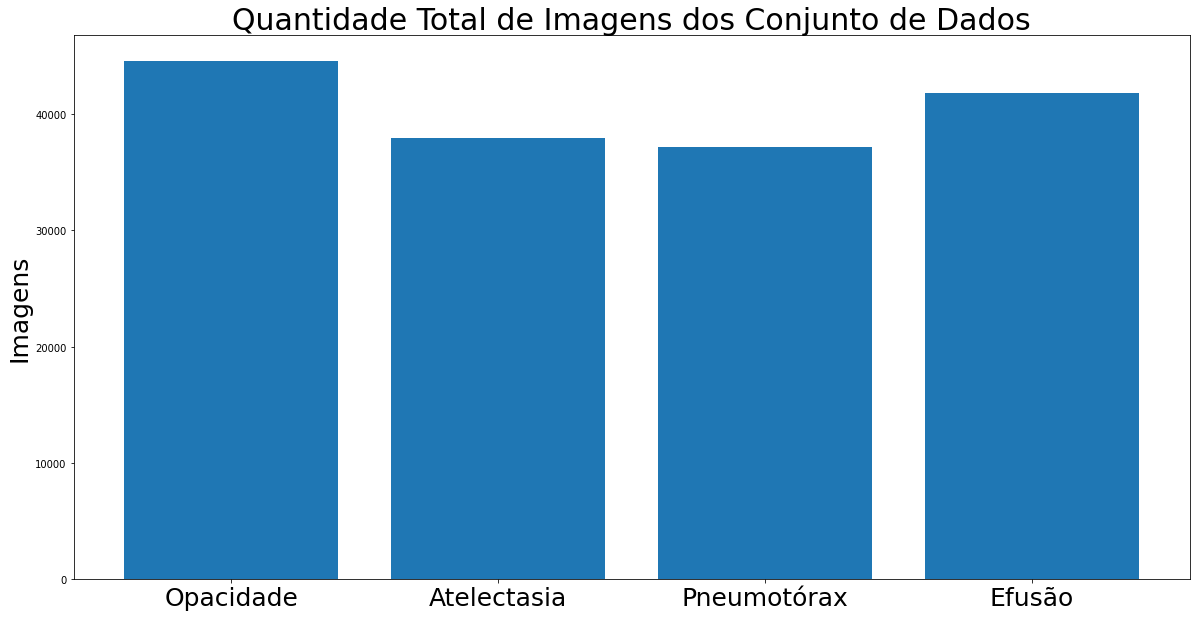

In [7]:
count_findings = list()
for finding in list(dataset.columns)[4:]:
  count = dict(dataset[finding].value_counts())[1.0]
  count_findings.append(count)

plt.figure(figsize = (20, 10))
plt.bar(labels_portugues, count_findings)
plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

In [8]:
opacity = np.array(dataset['Opacity']).astype(str)
atelectasis = np.array(dataset['Atelectasis']).astype(str)
pneumothorax = np.array(dataset['Pneumothorax']).astype(str)
effusion = np.array(dataset['Effusion']).astype(str)

all_labels = np.zeros(effusion.shape).astype(str)
for index in range(0, len(opacity)):
  all_labels[index] = opacity[index] + atelectasis[index] + pneumothorax[index]
  all_labels[index] += effusion[index]

dataset['labels_ref'] = all_labels

In [9]:
f_train, f_val = train_test_split(dataset, test_size = 0.2, random_state = 42, 
                                  stratify = dataset['labels_ref'])
f_val, f_test = train_test_split(f_val, test_size = 0.5, random_state = 42, 
                                 stratify = f_val['labels_ref'])

f_train.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_val.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_test.drop(labels = ['labels_ref'], axis = 1, inplace = True)

Text(0, 0.5, 'Imagens')

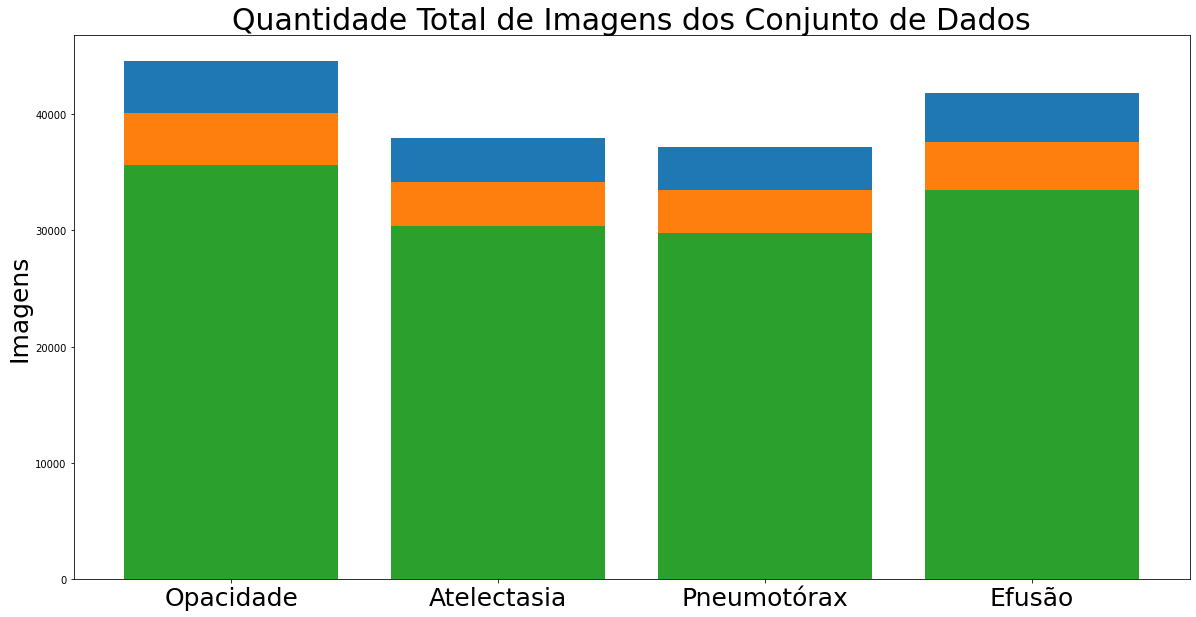

In [10]:
count_train, count_val, count_test = [], [], []
for finding in list(f_train.columns)[4:]:
  c_train = dict(f_train[finding].value_counts())[1.0]
  c_val = dict(f_val[finding].value_counts())[1.0]
  c_test = dict(f_test[finding].value_counts())[1.0]
  count_train.append(c_train), count_val.append(c_val), count_test.append(c_test)

plt.figure(figsize = (20, 10))
plt.bar(labels_portugues, np.sum((count_train, count_val, count_test), axis = 0))
plt.bar(labels_portugues, np.sum((count_train, count_val), axis = 0))
plt.bar(labels_portugues, count_train)
plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

### Gerador de Imagens do Keras

In [11]:
image_size, batch_size = 224, 64

In [12]:
core_idg_train1 = ImageDataGenerator(preprocessing_function = tf.keras.applications.densenet.preprocess_input, 
                                     rotation_range = 3, width_shift_range = 0.05, height_shift_range = 0.05, 
                                     fill_mode = 'constant')
core_idg_train2 = ImageDataGenerator(preprocessing_function = tf.keras.applications.inception_v3.preprocess_input, 
                                     rotation_range = 3, width_shift_range = 0.05, height_shift_range = 0.05, 
                                     fill_mode = 'constant')
core_idg_train3 = ImageDataGenerator(preprocessing_function = tf.keras.applications.xception.preprocess_input, 
                                     rotation_range = 3, width_shift_range = 0.05, height_shift_range = 0.05, 
                                     fill_mode = 'constant')
core_idg_train4 = ImageDataGenerator(preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input, 
                                     rotation_range = 3, width_shift_range = 0.05, height_shift_range = 0.05, 
                                     fill_mode = 'constant')
core_idg_train5 = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet_v2.preprocess_input, 
                                     rotation_range = 3, width_shift_range = 0.05, height_shift_range = 0.05, 
                                     fill_mode = 'constant')

In [13]:
core_idg_test1 = ImageDataGenerator(preprocessing_function = tf.keras.applications.densenet.preprocess_input)
core_idg_test2 = ImageDataGenerator(preprocessing_function = tf.keras.applications.inception_v3.preprocess_input)
core_idg_test3 = ImageDataGenerator(preprocessing_function = tf.keras.applications.xception.preprocess_input)
core_idg_test4 = ImageDataGenerator(preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input)
core_idg_test5 = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet_v2.preprocess_input)

In [14]:
train_gen1 = core_idg_train1.flow_from_dataframe(dataframe = f_train, directory = None, 
                                                 x_col = 'Path', y_col = labels, 
                                                 class_mode = 'raw', 
                                                 batch_size = batch_size,
                                                 target_size = (image_size, image_size), 
                                                 shuffle = True)
train_gen2 = core_idg_train2.flow_from_dataframe(dataframe = f_train, directory = None, 
                                                 x_col = 'Path', y_col = labels, 
                                                 class_mode = 'raw', 
                                                 batch_size = batch_size,
                                                 target_size = (image_size, image_size), 
                                                 shuffle = True)
train_gen3 = core_idg_train3.flow_from_dataframe(dataframe = f_train, directory = None, 
                                                 x_col = 'Path', y_col = labels, 
                                                 class_mode = 'raw', 
                                                 batch_size = batch_size,
                                                 target_size = (image_size, image_size), 
                                                 shuffle = True)
train_gen4 = core_idg_train4.flow_from_dataframe(dataframe = f_train, directory = None, 
                                                 x_col = 'Path', y_col = labels, 
                                                 class_mode = 'raw', 
                                                 batch_size = batch_size,
                                                 target_size = (image_size, image_size), 
                                                 shuffle = True)
train_gen5 = core_idg_train5.flow_from_dataframe(dataframe = f_train, directory = None, 
                                                 x_col = 'Path', y_col = labels, 
                                                 class_mode = 'raw', 
                                                 batch_size = batch_size,
                                                 target_size = (image_size, image_size), 
                                                 shuffle = True)

Found 70159 validated image filenames.
Found 70159 validated image filenames.
Found 70159 validated image filenames.
Found 70159 validated image filenames.
Found 70159 validated image filenames.


In [15]:
valid_gen1 = core_idg_test1.flow_from_dataframe(dataframe = f_val, directory = None, 
                                                x_col = 'Path',  y_col = labels, 
                                                class_mode = 'raw', 
                                                batch_size = batch_size,
                                                target_size = (image_size, image_size),
                                                shuffle = False)
valid_gen2 = core_idg_test2.flow_from_dataframe(dataframe = f_val, directory = None, 
                                                x_col = 'Path',  y_col = labels, 
                                                class_mode = 'raw', 
                                                batch_size = batch_size,
                                                target_size = (image_size, image_size),
                                                shuffle = False)
valid_gen3 = core_idg_test3.flow_from_dataframe(dataframe = f_val, directory = None, 
                                                x_col = 'Path',  y_col = labels, 
                                                class_mode = 'raw', 
                                                batch_size = batch_size,
                                                target_size = (image_size, image_size),
                                                shuffle = False)
valid_gen4 = core_idg_test4.flow_from_dataframe(dataframe = f_val, directory = None, 
                                                x_col = 'Path',  y_col = labels, 
                                                class_mode = 'raw', 
                                                batch_size = batch_size,
                                                target_size = (image_size, image_size),
                                                shuffle = False)
valid_gen5 = core_idg_test5.flow_from_dataframe(dataframe = f_val, directory = None, 
                                                x_col = 'Path',  y_col = labels, 
                                                class_mode = 'raw', 
                                                batch_size = batch_size,
                                                target_size = (image_size, image_size),
                                                shuffle = False)

y_labels_valid1 = valid_gen1.labels
y_labels_valid2 = valid_gen2.labels
y_labels_valid3 = valid_gen3.labels
y_labels_valid4 = valid_gen4.labels
y_labels_valid5 = valid_gen5.labels

Found 8770 validated image filenames.
Found 8770 validated image filenames.
Found 8770 validated image filenames.
Found 8770 validated image filenames.
Found 8770 validated image filenames.


In [16]:
test_gen1 = core_idg_test1.flow_from_dataframe(dataframe = f_test, directory = None, 
                                               x_col = 'Path', y_col = labels, 
                                               class_mode = 'raw', batch_size = batch_size,
                                               target_size = (image_size, image_size),
                                               shuffle = False)
test_gen2 = core_idg_test2.flow_from_dataframe(dataframe = f_test, directory = None, 
                                               x_col = 'Path', y_col = labels, 
                                               class_mode = 'raw', batch_size = batch_size,
                                               target_size = (image_size, image_size),
                                               shuffle = False)
test_gen3 = core_idg_test3.flow_from_dataframe(dataframe = f_test, directory = None, 
                                               x_col = 'Path', y_col = labels, 
                                               class_mode = 'raw', batch_size = batch_size,
                                               target_size = (image_size, image_size),
                                               shuffle = False)                                                                                             
test_gen4 = core_idg_test4.flow_from_dataframe(dataframe = f_test, directory = None, 
                                               x_col = 'Path', y_col = labels, 
                                               class_mode = 'raw', batch_size = batch_size,
                                               target_size = (image_size, image_size),
                                               shuffle = False)
test_gen5 = core_idg_test5.flow_from_dataframe(dataframe = f_test, directory = None, 
                                               x_col = 'Path', y_col = labels, 
                                               class_mode = 'raw', batch_size = batch_size,
                                               target_size = (image_size, image_size),
                                               shuffle = False)

y_labels_test1 = test_gen1.labels
y_labels_test2 = test_gen2.labels
y_labels_test3 = test_gen3.labels
y_labels_test4 = test_gen4.labels
y_labels_test5 = test_gen5.labels

Found 8770 validated image filenames.
Found 8770 validated image filenames.
Found 8770 validated image filenames.
Found 8770 validated image filenames.
Found 8770 validated image filenames.


### Organizando uma Função Utilitária de Callback

In [35]:
def get_callbacks(model_name, monitor = 'val_acc'):
    '''
    gerando uma lista de callbacks úteis para o treinamento da rede

    Args:
        model_name (str) --> nome do modelo em análise
        monitor (str) --> métrica de análise a ser monitorada pelo callback

    Returns:
        callbacks (list) --> Lista de callbacks
    '''
    checkpoint_file = f'model.{model_name}.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_file,
                                                    verbose = 1, 
                                                    save_best_only = True, 
                                                    monitor = monitor, 
                                                    mode = 'max')
    
    return [checkpoint]

### Definindo uma Função de Congelamento de Camadas

In [36]:
def freeze_layers(conv_base, layer_name):
  '''
  método de treinamento por congelamento de camadas das redes convolucionais

  Args:
    conv_base (tensor) --> camadas convolucionais do modelo
    layer_name (str) --> nome de referência da camada a ser iniciado o 
    congelamento
  '''

  conv_base.trainable = True
  set_trainable = False

  for layer in conv_base.layers:
    if layer.name == layer_name: set_trainable = True
    if set_trainable: layer.trainable = True
    else: layer.trainable = False
  
  return None

### Definindo uma Função de Binarização das Predições

In [37]:
def binarize_preds(pred_array, column, threshold):
  '''
  função que binariza as predições mutirrótulo do modelo

  Args:
    pred_array (array) --> vetor com as predições multirrótulo
    column (int) --> coluna do vetor multirrótulo a ser analisada
    threshold (float) --> valor de threshold a ser considerado na predição
  
  Returns:
    pred_bin (array) --> vetor de predição com os valores binarizados
  '''
  per_100 = pred_array[:,column] * 100
  pred_bin = list()
  for value in per_100:
    if value >= threshold: pred_bin.append(1)
    else: pred_bin.append(0)
  
  return pred_bin

### DenseNet121

In [ ]:
base_model = DenseNet121(include_top = False, weights = 'imagenet', 
                            input_shape = (image_size, image_size, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
densenet = tf.keras.Model(base_model.input, output)
densenet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                 loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                 metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks(model_name = 'densenet', monitor = 'val_auc')

In [39]:
layers_name = list()
for layer in base_model.layers:
  layers_name.append(layer.name)

block_names = ['input_1', 'conv4_block5_0_relu', 'conv5_block4_concat']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco input_1 found!
Bloco conv4_block5_0_relu found!
Bloco conv5_block4_concat found!


In [40]:
freeze_layers(conv_base = base_model, layer_name = block_names[2])
densenet.fit(train_gen1, validation_data = valid_gen1, epochs = 5, 
             callbacks = callbacks, use_multiprocessing = True, 
             workers = 8)

Epoch 1/5
1097/1097 [==============================] - ETA: 0s - loss: 0.5694 - auc: 0.7612
Epoch 1: val_auc improved from -inf to 0.72759, saving model to model.densenet.h5
1097/1097 [==============================] - 577s 501ms/step - loss: 0.5694 - auc: 0.7612 - val_loss: 1.0439 - val_auc: 0.7276
Epoch 2/5
1097/1097 [==============================] - ETA: 0s - loss: 0.5309 - auc: 0.7971
Epoch 2: val_auc improved from 0.72759 to 0.78336, saving model to model.densenet.h5
1097/1097 [==============================] - 529s 478ms/step - loss: 0.5309 - auc: 0.7971 - val_loss: 0.6226 - val_auc: 0.7834
Epoch 3/5
1097/1097 [==============================] - ETA: 0s - loss: 0.5160 - auc: 0.8103
Epoch 3: val_auc did not improve from 0.78336
1097/1097 [==============================] - 525s 475ms/step - loss: 0.5160 - auc: 0.8103 - val_loss: 0.7987 - val_auc: 0.7661
Epoch 4/5
1097/1097 [==============================] - ETA: 0s - loss: 0.5020 - auc: 0.8217
Epoch 4: val_auc did not improve from 

In [ ]:
densenet.load_weights('/content/model.densenet.h5')
densenet.save('model_densenet1')
shutil.make_archive(base_name = 'model_densenet1', format = 'zip', 
                    root_dir = '/content/model_densenet1')
shutil.move('/content/model_densenet1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/DenseNet121')

In [43]:
freeze_layers(conv_base = base_model, layer_name = block_names[1])
densenet.fit(train_gen1, validation_data = valid_gen1, epochs = 5, 
             callbacks = callbacks, use_multiprocessing = True, 
             workers = 8)

Epoch 1/5
1097/1097 [==============================] - ETA: 0s - loss: 0.4772 - auc: 0.8410
Epoch 1: val_auc did not improve from 0.80718
1097/1097 [==============================] - 523s 473ms/step - loss: 0.4772 - auc: 0.8410 - val_loss: 0.5329 - val_auc: 0.8072
Epoch 2/5
1097/1097 [==============================] - ETA: 0s - loss: 0.4631 - auc: 0.8510
Epoch 2: val_auc improved from 0.80718 to 0.80995, saving model to model.densenet.h5
1097/1097 [==============================] - 525s 474ms/step - loss: 0.4631 - auc: 0.8510 - val_loss: 0.5548 - val_auc: 0.8100
Epoch 3/5
1097/1097 [==============================] - ETA: 0s - loss: 0.4480 - auc: 0.8611
Epoch 3: val_auc improved from 0.80995 to 0.81077, saving model to model.densenet.h5
1097/1097 [==============================] - 522s 471ms/step - loss: 0.4480 - auc: 0.8611 - val_loss: 0.6586 - val_auc: 0.8108
Epoch 4/5
1097/1097 [==============================] - ETA: 0s - loss: 0.4338 - auc: 0.8708
Epoch 4: val_auc improved from 0.81

In [ ]:
densenet.load_weights('/content/model.densenet.h5')
densenet.save('model_densenet2')
shutil.make_archive(base_name = 'model_densenet2', format = 'zip', 
                    root_dir = '/content/model_densenet2')
shutil.move('/content/model_densenet2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/DenseNet121')

In [45]:
freeze_layers(conv_base = base_model, layer_name = block_names[0])
densenet.fit(train_gen1, validation_data = valid_gen1, epochs = 5, 
             callbacks = callbacks, use_multiprocessing = True, 
             workers = 8)

Epoch 1/5
1097/1097 [==============================] - ETA: 0s - loss: 0.3968 - auc: 0.8928
Epoch 1: val_auc improved from 0.83435 to 0.83774, saving model to model.densenet.h5
1097/1097 [==============================] - 531s 481ms/step - loss: 0.3968 - auc: 0.8928 - val_loss: 0.5028 - val_auc: 0.8377
Epoch 2/5
1097/1097 [==============================] - ETA: 0s - loss: 0.3791 - auc: 0.9027
Epoch 2: val_auc improved from 0.83774 to 0.84424, saving model to model.densenet.h5
1097/1097 [==============================] - 528s 478ms/step - loss: 0.3791 - auc: 0.9027 - val_loss: 0.5104 - val_auc: 0.8442
Epoch 3/5
1097/1097 [==============================] - ETA: 0s - loss: 0.3595 - auc: 0.9128
Epoch 3: val_auc improved from 0.84424 to 0.84965, saving model to model.densenet.h5
1097/1097 [==============================] - 524s 475ms/step - loss: 0.3595 - auc: 0.9128 - val_loss: 0.5147 - val_auc: 0.8497
Epoch 4/5
1097/1097 [==============================] - ETA: 0s - loss: 0.3416 - auc: 0.9

In [ ]:
densenet.load_weights('/content/model.densenet.h5')
densenet.save('model_densenet3')
shutil.make_archive(base_name = 'model_densenet3', format = 'zip', 
                    root_dir = '/content/model_densenet3')
shutil.move('/content/model_densenet3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/DenseNet121')

In [ ]:
shutil.move('/content/model.densenet.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/DenseNet121')

In [104]:
y_pred_val = densenet.predict(valid_gen1)
y_pred = densenet.predict(test_gen1)
print(f'AUC | Dados de Validação = {densenet.evaluate(valid_gen1)[1] * 100} %')
print(f'AUC | Dados de Teste = {densenet.evaluate(test_gen1)[1] * 100} %')

138/138 [==============================] - 50s 363ms/step - loss: 0.5539 - auc: 0.8592
AUC | Dados de Validação = 85.91752052307129 %
138/138 [==============================] - 51s 366ms/step - loss: 0.5447 - auc: 0.8628
AUC | Dados de Teste = 86.28153800964355 %


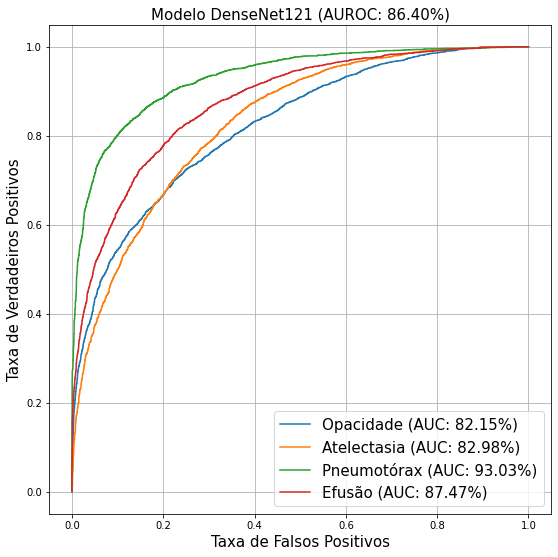

In [105]:
labels_portugues = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test1[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test1.astype(int), y_pred)*100)[0:5]
c_ax.set_title('Modelo DenseNet121 (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)

In [106]:
threshold_variation = dict()
for label_index in range(0, len(labels)):
  threshold_variation[label_index] = list()
  for threshold in range(1, 100):
    y_pred_bin = binarize_preds(pred_array = y_pred_val, column = label_index, 
                                threshold = threshold)
    matrix = confusion_matrix(y_labels_valid1[:, label_index], y_pred_bin)
    acc = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
    threshold_variation[label_index].append(acc)

bests_thresholds = list()
for label_index in range(0, len(labels)):
   for threshold in range(1, 100):
     if threshold_variation[label_index][threshold] == np.max(threshold_variation[label_index]):
       bests_thresholds.append(threshold)
       break

In [107]:
for label_index in range(0, len(labels)):
  y_pred_bin = binarize_preds(pred_array = y_pred, column = label_index, 
                              threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(y_labels_test1[:, label_index], y_pred_bin)
  acc = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
  precision = matrix[0,0]/(matrix[0,0]+matrix[0,1])
  recall = matrix[0,0]/(matrix[0,0]+matrix[1,0])
  f1_score = (2*precision*recall) / (precision + recall) 
  print(f'=={labels_portugues[label_index]}== \n{matrix},' 
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc*100} % | Precisão = {precision*100} % | '
        f'\nSensibilidade = {recall*100} % | F1 Score = {f1_score*100} %\n')

==Opacidade== 
[[3348  964]
 [1342 3116]], Threshold = 41
Acurácia = 73.70581527936146 % | Precisão = 77.64378478664193 % | 
Sensibilidade = 71.3859275053305 % | F1 Score = 74.38347033992447 %

==Atelectasia== 
[[3881 1089]
 [1153 2647]], Threshold = 54
Acurácia = 74.43557582668187 % | Precisão = 78.08853118712274 % | 
Sensibilidade = 77.09574890742948 % | F1 Score = 77.58896441423431 %

==Pneumotórax== 
[[4534  518]
 [ 728 2990]], Threshold = 93
Acurácia = 85.79247434435577 % | Precisão = 89.74663499604118 % | 
Sensibilidade = 86.16495629038388 % | F1 Score = 87.91933294551096 %

==Efusão== 
[[3792  798]
 [1050 3130]], Threshold = 34
Acurácia = 78.92816419612315 % | Precisão = 82.61437908496731 % | 
Sensibilidade = 78.31474597273854 % | F1 Score = 80.40712468193385 %



### InceptionV3

In [57]:
base_model = InceptionV3(include_top = False, weights = 'imagenet', 
                         input_shape = (image_size, image_size, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
inception = tf.keras.Model(base_model.input, output)
inception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                  loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                  metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks(model_name = 'inception', monitor = 'val_auc_2')

In [63]:
layers_name = list()
for layer in base_model.layers:
  layers_name.append(layer.name)

block_names = ['input_3', 'batch_normalization_160', 'mixed8']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco input_3 found!
Bloco batch_normalization_160 found!
Bloco mixed8 found!


In [64]:
freeze_layers(conv_base = base_model, layer_name = block_names[2])
inception.fit(train_gen2, validation_data = valid_gen2, epochs = 5, 
              callbacks = callbacks, use_multiprocessing = True, 
              workers = 8)

Epoch 1/5
1097/1097 [==============================] - ETA: 0s - loss: 0.5642 - auc_2: 0.7655
Epoch 1: val_auc_2 improved from -inf to 0.77456, saving model to model.inception.h5
1097/1097 [==============================] - 527s 470ms/step - loss: 0.5642 - auc_2: 0.7655 - val_loss: 0.6318 - val_auc_2: 0.7746
Epoch 2/5
1097/1097 [==============================] - ETA: 0s - loss: 0.5222 - auc_2: 0.8054
Epoch 2: val_auc_2 improved from 0.77456 to 0.79728, saving model to model.inception.h5
1097/1097 [==============================] - 518s 468ms/step - loss: 0.5222 - auc_2: 0.8054 - val_loss: 0.5849 - val_auc_2: 0.7973
Epoch 3/5
1097/1097 [==============================] - ETA: 0s - loss: 0.5033 - auc_2: 0.8210
Epoch 3: val_auc_2 did not improve from 0.79728
1097/1097 [==============================] - 521s 471ms/step - loss: 0.5033 - auc_2: 0.8210 - val_loss: 0.6075 - val_auc_2: 0.7793
Epoch 4/5
1097/1097 [==============================] - ETA: 0s - loss: 0.4864 - auc_2: 0.8341
Epoch 4: v

In [ ]:
inception.load_weights('/content/model.inception.h5')
inception.save('model_inception1')
shutil.make_archive(base_name = 'model_inception1', format = 'zip', 
                    root_dir = '/content/model_inception1')
shutil.move('/content/model_inception1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/InceptionV3')

In [66]:
freeze_layers(conv_base = base_model, layer_name = block_names[1])
inception.fit(train_gen2, validation_data = valid_gen2, epochs = 5, 
              callbacks = callbacks, use_multiprocessing = True, 
              workers = 8)

Epoch 1/5
1097/1097 [==============================] - ETA: 0s - loss: 0.4712 - auc_2: 0.8450
Epoch 1: val_auc_2 did not improve from 0.81157
1097/1097 [==============================] - 523s 473ms/step - loss: 0.4712 - auc_2: 0.8450 - val_loss: 0.7353 - val_auc_2: 0.7962
Epoch 2/5
1097/1097 [==============================] - ETA: 0s - loss: 0.4525 - auc_2: 0.8582
Epoch 2: val_auc_2 improved from 0.81157 to 0.82119, saving model to model.inception.h5
1097/1097 [==============================] - 524s 474ms/step - loss: 0.4525 - auc_2: 0.8582 - val_loss: 0.5462 - val_auc_2: 0.8212
Epoch 3/5
1097/1097 [==============================] - ETA: 0s - loss: 0.4322 - auc_2: 0.8712
Epoch 3: val_auc_2 did not improve from 0.82119
1097/1097 [==============================] - 525s 475ms/step - loss: 0.4322 - auc_2: 0.8712 - val_loss: 0.7843 - val_auc_2: 0.7861
Epoch 4/5
1097/1097 [==============================] - ETA: 0s - loss: 0.4112 - auc_2: 0.8840
Epoch 4: val_auc_2 improved from 0.82119 to 0.8

In [ ]:
inception.load_weights('/content/model.inception.h5')
inception.save('model_inception2')
shutil.make_archive(base_name = 'model_inception2', format = 'zip', 
                    root_dir = '/content/model_inception2')
shutil.move('/content/model_inception2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/InceptionV3')

In [68]:
freeze_layers(conv_base = base_model, layer_name = block_names[0])
inception.fit(train_gen2, validation_data = valid_gen2, epochs = 5, 
              callbacks = callbacks, use_multiprocessing = True, 
              workers = 8)

Epoch 1/5
1097/1097 [==============================] - ETA: 0s - loss: 0.3841 - auc_2: 0.8996
Epoch 1: val_auc_2 did not improve from 0.82730
1097/1097 [==============================] - 523s 473ms/step - loss: 0.3841 - auc_2: 0.8996 - val_loss: 0.6109 - val_auc_2: 0.8248
Epoch 2/5
1097/1097 [==============================] - ETA: 0s - loss: 0.3619 - auc_2: 0.9111
Epoch 2: val_auc_2 improved from 0.82730 to 0.83105, saving model to model.inception.h5
1097/1097 [==============================] - 522s 472ms/step - loss: 0.3619 - auc_2: 0.9111 - val_loss: 0.6047 - val_auc_2: 0.8310
Epoch 3/5
1097/1097 [==============================] - ETA: 0s - loss: 0.3393 - auc_2: 0.9221
Epoch 3: val_auc_2 did not improve from 0.83105
1097/1097 [==============================] - 521s 471ms/step - loss: 0.3393 - auc_2: 0.9221 - val_loss: 0.7401 - val_auc_2: 0.8247
Epoch 4/5
1097/1097 [==============================] - ETA: 0s - loss: 0.3151 - auc_2: 0.9328
Epoch 4: val_auc_2 improved from 0.83105 to 0.8

In [ ]:
inception.load_weights('/content/model.inception.h5')
inception.save('model_inception3')
shutil.make_archive(base_name = 'model_inception3', format = 'zip', 
                    root_dir = '/content/model_inception3')
shutil.move('/content/model_inception3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/InceptionV3')

In [ ]:
shutil.move('/content/model.inception.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/InceptionV3')

In [100]:
y_pred_val = inception.predict(valid_gen2)
y_pred = inception.predict(test_gen2)
print(f'AUC | Dados de Validação = {densenet.evaluate(valid_gen2)[1] * 100} %')
print(f'AUC | Dados de Teste = {densenet.evaluate(test_gen2)[1] * 100} %')

138/138 [==============================] - 48s 344ms/step - loss: 0.6176 - auc: 0.7901
AUC | Dados de Validação = 79.00828123092651 %
138/138 [==============================] - 49s 353ms/step - loss: 0.6090 - auc: 0.7937
AUC | Dados de Teste = 79.37108278274536 %


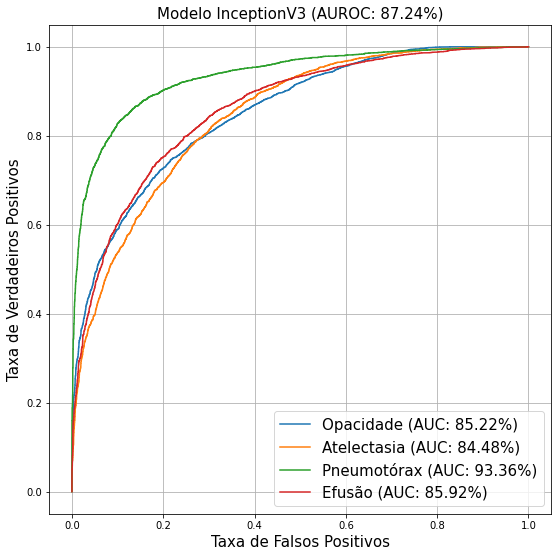

In [101]:
labels_portugues = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test2[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test2.astype(int), y_pred)*100)[0:5]
c_ax.set_title('Modelo InceptionV3 (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)

In [102]:
threshold_variation = dict()
for label_index in range(0, len(labels)):
  threshold_variation[label_index] = list()
  for threshold in range(1, 100):
    y_pred_bin = binarize_preds(pred_array = y_pred_val, column = label_index, 
                                threshold = threshold)
    matrix = confusion_matrix(y_labels_valid2[:, label_index], y_pred_bin)
    acc = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
    threshold_variation[label_index].append(acc)

bests_thresholds = list()
for label_index in range(0, len(labels)):
   for threshold in range(1, 100):
     if threshold_variation[label_index][threshold] == np.max(threshold_variation[label_index]):
       bests_thresholds.append(threshold)
       break

In [103]:
for label_index in range(0, len(labels)):
  y_pred_bin = binarize_preds(pred_array = y_pred, column = label_index, 
                              threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(y_labels_test2[:, label_index], y_pred_bin)
  acc = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
  precision = matrix[0,0]/(matrix[0,0]+matrix[0,1])
  recall = matrix[0,0]/(matrix[0,0]+matrix[1,0])
  f1_score = (2*precision*recall) / (precision + recall) 
  print(f'=={labels_portugues[label_index]}== \n{matrix},' 
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc*100} % | Precisão = {precision*100} % | '
        f'\nSensibilidade = {recall*100} % | F1 Score = {f1_score*100} %\n')

==Opacidade== 
[[3361  951]
 [1121 3337]], Threshold = 58
Acurácia = 76.37400228050171 % | Precisão = 77.9452690166976 % | 
Sensibilidade = 74.98884426595271 % | F1 Score = 76.43848078235162 %

==Atelectasia== 
[[4024  946]
 [1198 2602]], Threshold = 48
Acurácia = 75.55302166476625 % | Precisão = 80.96579476861166 % | 
Sensibilidade = 77.05859823822291 % | F1 Score = 78.96389324960754 %

==Pneumotórax== 
[[4508  544]
 [ 611 3107]], Threshold = 44
Acurácia = 86.83010262257696 % | Precisão = 89.2319873317498 % | 
Sensibilidade = 88.0640750146513 % | F1 Score = 88.64418444597385 %

==Efusão== 
[[3695  895]
 [1051 3129]], Threshold = 58
Acurácia = 77.81071835803877 % | Precisão = 80.50108932461873 % | 
Sensibilidade = 77.85503581963759 % | F1 Score = 79.15595544130248 %



### Xception

In [ ]:
base_model = Xception(include_top = False, weights = 'imagenet', 
                      input_shape = (image_size, image_size, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
xception = tf.keras.Model(base_model.input, output)
xception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                 loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                 metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks(model_name = 'xception', monitor = 'val_auc_3')

In [88]:
layers_name = list()
for layer in base_model.layers:
  layers_name.append(layer.name)

block_names = ['input_4', 'block6_sepconv3_act', 'block11_sepconv3_bn']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco input_4 found!
Bloco block6_sepconv3_act found!
Bloco block11_sepconv3_bn found!


In [89]:
freeze_layers(conv_base = base_model, layer_name = block_names[2])
xception.fit(train_gen3, validation_data = valid_gen3, epochs = 5, 
             callbacks = callbacks, use_multiprocessing = True, 
             workers = 8)

Epoch 1/5
1097/1097 [==============================] - ETA: 0s - loss: 0.5424 - auc_3: 0.7865
Epoch 1: val_auc_3 improved from -inf to 0.80372, saving model to model.xception.h5
1097/1097 [==============================] - 885s 798ms/step - loss: 0.5424 - auc_3: 0.7865 - val_loss: 0.5511 - val_auc_3: 0.8037
Epoch 2/5
1097/1097 [==============================] - ETA: 0s - loss: 0.4944 - auc_3: 0.8280
Epoch 2: val_auc_3 did not improve from 0.80372
1097/1097 [==============================] - 873s 792ms/step - loss: 0.4944 - auc_3: 0.8280 - val_loss: 0.5706 - val_auc_3: 0.7810
Epoch 3/5
1097/1097 [==============================] - ETA: 0s - loss: 0.4678 - auc_3: 0.8473
Epoch 3: val_auc_3 improved from 0.80372 to 0.82137, saving model to model.xception.h5
1097/1097 [==============================] - 874s 792ms/step - loss: 0.4678 - auc_3: 0.8473 - val_loss: 0.5589 - val_auc_3: 0.8214
Epoch 4/5
1097/1097 [==============================] - ETA: 0s - loss: 0.4426 - auc_3: 0.8645
Epoch 4: val

In [ ]:
xception.load_weights('/content/model.xception.h5')
xception.save('model_xception1')
shutil.make_archive(base_name = 'model_xception1', format = 'zip', 
                    root_dir = '/content/model_xception1')
shutil.move('/content/model_xception1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/Xception')

In [91]:
freeze_layers(conv_base = base_model, layer_name = block_names[1])
xception.fit(train_gen3, validation_data = valid_gen3, epochs = 5, 
             callbacks = callbacks, use_multiprocessing = True, 
             workers = 8)

Epoch 1/5
1097/1097 [==============================] - ETA: 0s - loss: 0.3792 - auc_3: 0.9021
Epoch 1: val_auc_3 improved from 0.84086 to 0.84558, saving model to model.xception.h5
1097/1097 [==============================] - 863s 783ms/step - loss: 0.3792 - auc_3: 0.9021 - val_loss: 0.5085 - val_auc_3: 0.8456
Epoch 2/5
1097/1097 [==============================] - ETA: 0s - loss: 0.3439 - auc_3: 0.9199
Epoch 2: val_auc_3 improved from 0.84558 to 0.87178, saving model to model.xception.h5
1097/1097 [==============================] - 863s 782ms/step - loss: 0.3439 - auc_3: 0.9199 - val_loss: 0.4751 - val_auc_3: 0.8718
Epoch 3/5
1097/1097 [==============================] - ETA: 0s - loss: 0.3101 - auc_3: 0.9350
Epoch 3: val_auc_3 improved from 0.87178 to 0.87844, saving model to model.xception.h5
1097/1097 [==============================] - 862s 781ms/step - loss: 0.3101 - auc_3: 0.9350 - val_loss: 0.4894 - val_auc_3: 0.8784
Epoch 4/5
1097/1097 [==============================] - ETA: 0s -

In [ ]:
xception.load_weights('/content/model.xception.h5')
xception.save('model_xception2')
shutil.make_archive(base_name = 'model_xception2', format = 'zip', 
                    root_dir = '/content/model_xception2')
shutil.move('/content/model_xception2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/Xception')

In [93]:
freeze_layers(conv_base = base_model, layer_name = block_names[0])
xception.fit(train_gen3, validation_data = valid_gen3, epochs = 5, 
             callbacks = callbacks, use_multiprocessing = True, 
             workers = 8)

Epoch 1/5
1097/1097 [==============================] - ETA: 0s - loss: 0.2701 - auc_3: 0.9506
Epoch 1: val_auc_3 did not improve from 0.87844
1097/1097 [==============================] - 863s 783ms/step - loss: 0.2701 - auc_3: 0.9506 - val_loss: 0.5494 - val_auc_3: 0.8632
Epoch 2/5
1097/1097 [==============================] - ETA: 0s - loss: 0.2462 - auc_3: 0.9590
Epoch 2: val_auc_3 improved from 0.87844 to 0.88300, saving model to model.xception.h5
1097/1097 [==============================] - 859s 779ms/step - loss: 0.2462 - auc_3: 0.9590 - val_loss: 0.4965 - val_auc_3: 0.8830
Epoch 3/5
1097/1097 [==============================] - ETA: 0s - loss: 0.2240 - auc_3: 0.9660
Epoch 3: val_auc_3 improved from 0.88300 to 0.88697, saving model to model.xception.h5
1097/1097 [==============================] - 859s 779ms/step - loss: 0.2240 - auc_3: 0.9660 - val_loss: 0.5309 - val_auc_3: 0.8870
Epoch 4/5
1097/1097 [==============================] - ETA: 0s - loss: 0.2036 - auc_3: 0.9719
Epoch 4: 

In [94]:
xception.load_weights('/content/model.xception.h5')
xception.save('model_xception3')
shutil.make_archive(base_name = 'model_xception3', format = 'zip', 
                    root_dir = '/content/model_xception3')
shutil.move('/content/model_xception3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/Xception')

'/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/Xception/model_xception3.zip'

In [95]:
shutil.move('/content/model.xception.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/Xception')

'/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/Xception/model.xception.h5'

In [96]:
y_pred_val = xception.predict(valid_gen3)
y_pred = xception.predict(test_gen3)
print(f'AUC | Dados de Validação = {xception.evaluate(valid_gen3)[1] * 100} %')
print(f'AUC | Dados de Teste = {xception.evaluate(test_gen3)[1] * 100} %')

138/138 [==============================] - 48s 343ms/step - loss: 0.5256 - auc_3: 0.8915
AUC | Dados de Validação = 89.14647698402405 %
138/138 [==============================] - 49s 354ms/step - loss: 0.5195 - auc_3: 0.8938
AUC | Dados de Teste = 89.38318490982056 %


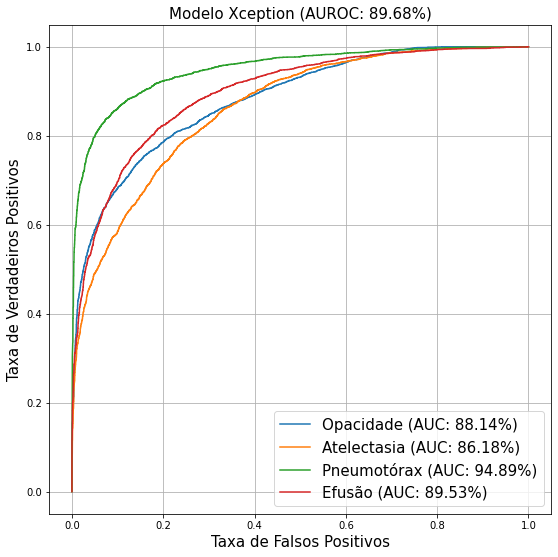

In [97]:
labels_portugues = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test3[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test3.astype(int), y_pred)*100)[0:5]
c_ax.set_title('Modelo Xception (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)

In [98]:
threshold_variation = dict()
for label_index in range(0, len(labels)):
  threshold_variation[label_index] = list()
  for threshold in range(1, 100):
    y_pred_bin = binarize_preds(pred_array = y_pred_val, column = label_index, 
                                threshold = threshold)
    matrix = confusion_matrix(y_labels_valid3[:, label_index], y_pred_bin)
    acc = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
    threshold_variation[label_index].append(acc)

bests_thresholds = list()
for label_index in range(0, len(labels)):
   for threshold in range(1, 100):
     if threshold_variation[label_index][threshold] == np.max(threshold_variation[label_index]):
       bests_thresholds.append(threshold)
       break

In [99]:
for label_index in range(0, len(labels)):
  y_pred_bin = binarize_preds(pred_array = y_pred, column = label_index, 
                              threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(y_labels_test2[:, label_index], y_pred_bin)
  acc = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
  precision = matrix[0,0]/(matrix[0,0]+matrix[0,1])
  recall = matrix[0,0]/(matrix[0,0]+matrix[1,0])
  f1_score = (2*precision*recall) / (precision + recall) 
  print(f'=={labels_portugues[label_index]}== \n{matrix},' 
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc*100} % | Precisão = {precision*100} % | '
        f'\nSensibilidade = {recall*100} % | F1 Score = {f1_score*100} %\n')

==Opacidade== 
[[3618  694]
 [1089 3369]], Threshold = 82
Acurácia = 79.66932725199544 % | Precisão = 83.90538033395177 % | 
Sensibilidade = 76.8642447418738 % | F1 Score = 80.23062423772035 %

==Atelectasia== 
[[4160  810]
 [1198 2602]], Threshold = 72
Acurácia = 77.10376282782212 % | Precisão = 83.70221327967808 % | 
Sensibilidade = 77.64091078760733 % | F1 Score = 80.55770720371804 %

==Pneumotórax== 
[[4681  371]
 [ 608 3110]], Threshold = 62
Acurácia = 88.8369441277081 % | Precisão = 92.65637371338083 % | 
Sensibilidade = 88.50444318396671 % | F1 Score = 90.53283048061115 %

==Efusão== 
[[3998  592]
 [1044 3136]], Threshold = 56
Acurácia = 81.34549600912202 % | Precisão = 87.10239651416121 % | 
Sensibilidade = 79.29393097976994 % | F1 Score = 83.01495016611295 %

